In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import json
import pandas as pd
from matplotlib import rc
from os.path import exists

plt.style.use('plotting.mplstyle')

**Warning**: This script assumes that you have cloned the repository hosting data for Galaudage+ 2021 (ApJL 921, L15): https://github.com/shanikagalaudage/bbh_spin


Specifically, it assumes that a link to this repository has been created in the following location:

```bash
../code/input/galaudage-data
```

If you have *not* cloned this repository, do the following (replace brackets with actual filepaths):

```bash
$ cd [...desired location...]
$ git clone git@github.com:shanikagalaudage/bbh_spin.git
$ cd [...gwtc3-spin-studies repository]/code/input/
$ ln -s [...path to bbh_spin] galaudage-data
```

In [2]:
# Read in pickled posterior samples 
posts = pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_1.pkl.bz2") \
    + pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_2.pkl.bz2")
posts_zero = pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_zero_1.pkl.bz2") \
    + pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_zero_2.pkl.bz2")

In [3]:
# Loop over events and directly computing spinning vs. non-spinning Bayes factors
# by reading off evidences under each model
direct_bayes = np.zeros(len(posts))
for i in range(len(posts)):
    
    spinning_ln_evidence = posts[i].ln_evidence.values[0]
    nonspinning_ln_evidence = posts_zero[i].ln_evidence.values[0]
    direct_bayes[i] = np.exp(nonspinning_ln_evidence-spinning_ln_evidence)

In [4]:
# Next, we can manually compute Bayes factors via Savage-Dickey ratios
# WARNING: This may take ~15 minutes to run the first time,
# due to the need to manually integrate over the KDE'd probability distributions and compute
# normalization constants

# Function to compute a Savage-Dickey non-spinning vs. spinning Bayes factor,
# assuming a uniform spin magnitude prior between 0 and chi_max
def get_SD_bayes(chi_max):

    # Set up a grid over spin magnitudes
    # We need this to normalize our KDE below
    a_grid = np.linspace(0,chi_max,60)
    A1,A2 = np.meshgrid(a_grid,a_grid)

    # Instantiate array to hold Savage-Dickey bayes factors and loop over events
    bayes = np.zeros(len(direct_bayes))
    for i in range(len(direct_bayes)):

        # Grab spin magnitude samples and limit to our desired prior range
        a1s = posts[i].a_1.values
        a2s = posts[i].a_2.values       
        toKeep = (a1s<=chi_max)*(a2s<=chi_max)
        a1s = a1s[toKeep]
        a2s = a2s[toKeep]

        # Build KDE and evaluate at the origin
        # Note that the factor of 4 implements our reflective boundary condition at the origin
        posterior_kde = gaussian_kde([a1s,a2s],bw_method=a1s.size**(-1./6.))
        posterior = 4.*posterior_kde([0,0])

        # We also need to normalize, since we haven't imposed any boundary condition at the high-spin end
        posterior /= np.sum(
            posterior_kde([A1.ravel(),A2.ravel()])
            + posterior_kde([-A1.ravel(),A2.ravel()])
            + posterior_kde([A1.ravel(),-A2.ravel()])
            + posterior_kde([-A1.ravel(),-A2.ravel()]))*(a_grid[1]-a_grid[0])**2       

        # Compute our SD bayes factor
        prior = 1./(chi_max**2)
        bayes[i] = posterior/prior

    return bayes

# Check to see if we've already run this cell and produced an output file
# with non-spinning vs. spinning Bayes factors
if exists("SD_bayes.json"):
    
    # If our output file already exists, read in the results
    with open("SD_bayes.json","r") as jf:
        bayesDictionary = json.load(jf)
        
    sd_bayes_chiMax_10 = np.array(bayesDictionary['chiMax_1.0'])
    sd_bayes_chiMax_09 = np.array(bayesDictionary['chiMax_0.9'])
    sd_bayes_chiMax_08 = np.array(bayesDictionary['chiMax_0.8'])

# Otherwise, generate fresh results!
else:

    sd_bayes_chiMax_10 = get_SD_bayes(1.)
    sd_bayes_chiMax_09 = get_SD_bayes(0.9)
    sd_bayes_chiMax_08 = get_SD_bayes(0.8)

    bayesDictionary = {
        'chiMax_1.0':sd_bayes_chiMax_10.tolist(),
        'chiMax_0.9':sd_bayes_chiMax_09.tolist(),
        'chiMax_0.8':sd_bayes_chiMax_08.tolist(),
    }

    with open('SD_bayes.json','w') as jf:
        json.dump(bayesDictionary,jf)

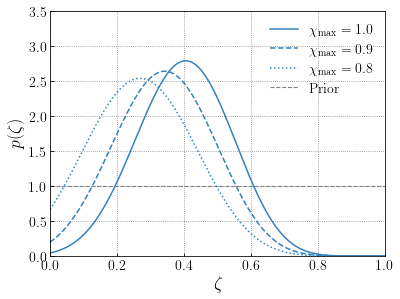

In [5]:
# Using our non-spinning vs. spinning Bayes factors above, we can compute the analytic
# posterior on the fraction of non-spinning systems

# Instantiate an array of possible zero-spin fractions
fs = np.linspace(0,1,300)

# Compute p(f)
p_fs_chiMax_10 = np.zeros_like(fs)
p_fs_chiMax_09 = np.zeros_like(fs)
p_fs_chiMax_08 = np.zeros_like(fs)
for i,f in enumerate(fs):
    p_fs_chiMax_10[i] = np.prod(sd_bayes_chiMax_10*f  + (1.-f))
    p_fs_chiMax_09[i] = np.prod(sd_bayes_chiMax_09*f  + (1.-f))
    p_fs_chiMax_08[i] = np.prod(sd_bayes_chiMax_08*f  + (1.-f))
    
# Plot!
fig,ax = plt.subplots()

ax.plot(fs,p_fs_chiMax_10/np.trapz(p_fs_chiMax_10,fs),color='#3182bd',label='$\chi_\mathrm{max} = 1.0$')
ax.plot(fs,p_fs_chiMax_09/np.trapz(p_fs_chiMax_09,fs),color='#3182bd',ls='--',label='$\chi_\mathrm{max} = 0.9$')
ax.plot(fs,p_fs_chiMax_08/np.trapz(p_fs_chiMax_08,fs),color='#3182bd',ls=':',label='$\chi_\mathrm{max} = 0.8$')
ax.plot(fs,np.ones_like(fs),color='black',alpha=0.5,lw=1.1,ls='--',zorder=-1,label='Prior')

ax.set_xlim(0,1)
ax.set_ylim(0,3.5)
ax.set_xlabel("$\zeta$")
ax.set_ylabel("$p(\zeta)$")
ax.legend()

plt.savefig('figure_01.pdf',bbox_inches='tight')
plt.show()

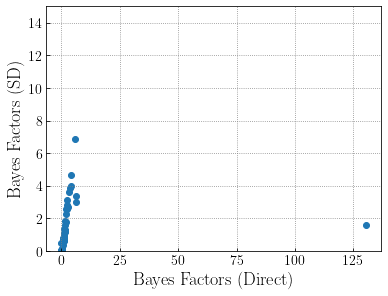

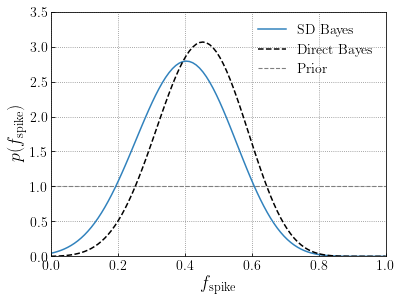

In [6]:
# As an additional check, let's compare p(f) obtained from our Savage-Dickey bayes factors
# with p(f) obtained from the direct bayes factors reported by Galaudage+.
# As reported in our main text, there is one event whose directly reported evidences appear corrupt.

# First, compare the Bayes factors themselves
fig,ax = plt.subplots()
ax.scatter(direct_bayes,sd_bayes_chiMax_10)
ax.set_ylim(0,15)
ax.set_xlabel('Bayes Factors (Direct)')
ax.set_ylabel('Bayes Factors (SD)')
plt.show()

# Temporarily ignore this corrupt event and proceed
# Instantiate an array of possible zero-spin fractions and compute p(f)
fs = np.linspace(0,1,100)
p_fs_SD = np.zeros_like(fs)
p_fs_direct = np.zeros_like(fs)
for i,f in enumerate(fs):
    p_fs_SD[i] = np.prod(sd_bayes_chiMax_10*f  + (1.-f))
    p_fs_direct[i] = np.prod(direct_bayes*f  + (1.-f))
    
# Plot!
fig,ax = plt.subplots()
ax.plot(fs,p_fs_SD/np.trapz(p_fs_SD,fs),color='#3182bd',label='SD Bayes')
ax.plot(fs,p_fs_direct/np.trapz(p_fs_direct,fs),color='black',ls='--',label='Direct Bayes')
ax.plot(fs,np.ones_like(fs),color='black',alpha=0.5,lw=1.1,ls='--',zorder=-1,label='Prior')
ax.set_xlim(0,1)
ax.set_ylim(0,3.5)
ax.set_xlabel("$f_\mathrm{spike}$")
ax.set_ylabel("$p(f_\mathrm{spike})$")
ax.legend()
plt.show()

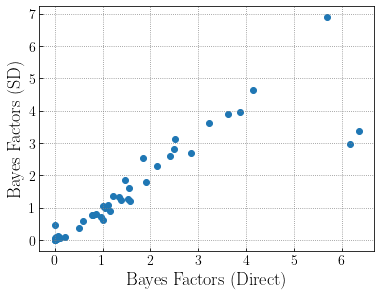

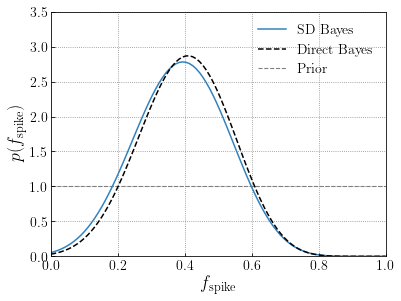

In [7]:
# The above curves don't agree terribly well.
# The issue is the corrupt Bayes factor estimate reported above.
# Redo this calculation with the event in question removed

sorting = np.argsort(direct_bayes)
direct_bayes_eventRemoved = direct_bayes[sorting][:-1]
sd_bayes_chiMax_10_eventRemoved = sd_bayes_chiMax_10[sorting][:-1]

# Compare the Bayes factors themselves
fig,ax = plt.subplots()
ax.scatter(direct_bayes_eventRemoved,sd_bayes_chiMax_10_eventRemoved)
ax.set_xlabel('Bayes Factors (Direct)')
ax.set_ylabel('Bayes Factors (SD)')
plt.show()

# Temporarily ignore this corrupt event and proceed
# Instantiate an array of possible zero-spin fractions and compute p(f)
fs = np.linspace(0,1,100)
p_fs_SD = np.zeros_like(fs)
p_fs_direct = np.zeros_like(fs)
for i,f in enumerate(fs):
    p_fs_SD[i] = np.prod(sd_bayes_chiMax_10_eventRemoved*f  + (1.-f))
    p_fs_direct[i] = np.prod(direct_bayes_eventRemoved*f  + (1.-f))
    
# Plot!
fig,ax = plt.subplots()
ax.plot(fs,p_fs_SD/np.trapz(p_fs_SD,fs),color='#3182bd',label='SD Bayes')
ax.plot(fs,p_fs_direct/np.trapz(p_fs_direct,fs),color='black',ls='--',label='Direct Bayes')
ax.plot(fs,np.ones_like(fs),color='black',alpha=0.5,lw=1.1,ls='--',zorder=-1,label='Prior')
ax.set_xlim(0,1)
ax.set_ylim(0,3.5)
ax.set_xlabel("$f_\mathrm{spike}$")
ax.set_ylabel("$p(f_\mathrm{spike})$")
ax.legend()
plt.show()